In [3]:
from __future__ import print_function,division
from builtins import range

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,GlobalMaxPool1D
from keras.layers import Conv1D,MaxPool1D,Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [8]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [15]:
print('Loading word vectors...')

word2vec = {}
with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf8") as f:

  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...

    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [16]:
train = pd.read_csv('train.csv')

In [131]:
test = pd.read_csv('test.csv')

In [132]:
test_lab = pd.read_csv('test_labels.csv')

In [151]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [17]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [134]:
sentences = train['comment_text'].fillna('DUMMY_VALUE').values

In [135]:
test_sent = test['comment_text'].fillna('DUMMY_VALUE').values

In [136]:
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [23]:
targets = train[possible_labels].values

In [24]:
targets

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [25]:
print('max sent length',max(len(s) for s in sentences))
print('min sent length',min(len(s) for s in sentences))

max sent length 5000
min sent length 6


In [137]:
print('max sent length',max(len(s) for s in test_sent))
print('min sent length',min(len(s) for s in test_sent))

max sent length 5000
min sent length 1


In [28]:
s = sorted(len(s) for s in sentences)
print('median sent length',s[len(s)//2])

median sent length 205


In [30]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
seqences = tokenizer.texts_to_sequences(sentences)

In [158]:
tokenizer_t = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_t.fit_on_texts(test_sent)
test_seqences = tokenizer_t.texts_to_sequences(test_sent)

In [144]:
word2idx = tokenizer.word_index

In [159]:
test_word2idx = tokenizer_t.word_index

In [160]:
print('found {} unique tokens'.format(len(test_word2idx)))

found 273192 unique tokens


In [ ]:
data = pad_sequences(seqences,maxlen=MAX_SEQUENCE_LENGTH)
data.shape

In [161]:
data_test = pad_sequences(test_seqences,maxlen=MAX_SEQUENCE_LENGTH)
data_test.shape

(153164, 100)

In [148]:
data_test

array([[    0,     0,     0, ..., 12896,  3426,  1532],
       [    0,     0,     0, ...,   657, 12547,   288],
       [    0,     0,     0, ...,     1,   752,   521],
       ...,
       [    0,     0,     0, ...,  7972,  3491,  4890],
       [    0,     0,     0, ...,   148,    28,    11],
       [    0,     0,     0, ...,  1711,  2082,    83]])

In [45]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():

    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
# words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [46]:
embedding_layer =Embedding(num_words,EMBEDDING_DIM,
                           weights = [embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,
                          trainable = False)

In [48]:
print('Building Model')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128,activation='relu')(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

Building Model


In [51]:
model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [52]:
print('Training Model')
#r = model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Training Model
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 283s 2ms/step - loss: 0.0834 - acc: 0.9733 - val_loss: 0.0938 - val_acc: 0.9708
Epoch 2/10
127656/127656 [==============================] - 241s 2ms/step - loss: 0.0677 - acc: 0.9773 - val_loss: 0.0694 - val_acc: 0.9770
Epoch 3/10
127656/127656 [==============================] - 243s 2ms/step - loss: 0.0633 - acc: 0.9785 - val_loss: 0.0710 - val_acc: 0.9756
Epoch 4/10
127656/127656 [==============================] - 243s 2ms/step - loss: 0.0604 - acc: 0.9792 - val_loss: 0.0776 - val_acc: 0.9766
Epoch 5/10
127656/127656 [==============================] - 239s 2ms/step - loss: 0.0582 - acc: 0.9797 - val_loss: 0.0712 - val_acc: 0.9777
Epoch 6/10
127656/127656 [==============================] - 240s 2ms/step - loss: 0.0564 - acc: 0.9803 - val_loss: 0.0906 - val_acc: 0.9751
Epoch 7/10
127656/127656 [==============================] - 240s 2ms/step - loss: 0.0549 - acc

In [69]:
#model.save('ToxicCMT.h5')

In [163]:
pred = model.predict(data_test)

In [169]:
pred

array([[9.8923546e-01, 2.2570664e-02, 9.0387899e-01, 5.1338336e-04,
        6.4012396e-01, 1.2826221e-01],
       [9.9966609e-01, 1.0955918e-01, 9.7781086e-01, 1.4494171e-03,
        7.3324776e-01, 2.3784159e-02],
       [6.9936566e-02, 7.9532736e-05, 2.2473106e-02, 3.5802048e-05,
        1.8311247e-02, 4.7454637e-04],
       ...,
       [1.3076543e-04, 1.4057741e-14, 4.2736947e-06, 2.2558421e-13,
        1.0003670e-06, 2.0328543e-10],
       [2.0267971e-02, 7.1215602e-08, 1.0796393e-03, 2.6255568e-06,
        8.0055068e-04, 7.0283553e-05],
       [1.0039380e-02, 8.0604167e-08, 1.8832262e-03, 3.9602546e-07,
        9.3524146e-04, 1.2500610e-05]], dtype=float32)

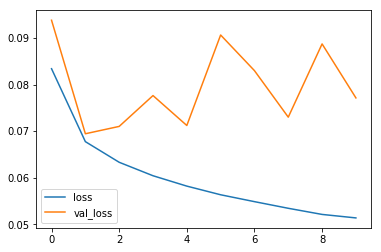

In [53]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

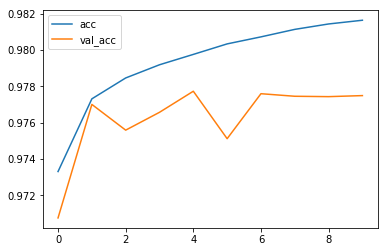

In [54]:
plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

In [55]:
p = model.predict(data)

aucs = []

for j in range(6):

    auc = roc_auc_score(targets[:,j], p[:,j])

    aucs.append(auc)

print(np.mean(aucs))

0.9754155930741026


In [87]:
print(p)

[[1.0819754e-06 8.3657443e-23 6.3172254e-09 7.2816885e-23 1.9475298e-10
  5.5484946e-17]
 [4.1721733e-03 1.4690306e-09 4.9828121e-04 4.7320690e-09 1.9160626e-04
  5.8514860e-07]
 [4.0603634e-03 1.0280006e-09 3.0805805e-04 1.6066961e-08 1.4113358e-04
  9.1527068e-07]
 ...
 [1.1826471e-01 9.7099582e-06 2.3286203e-02 1.0711925e-05 1.0693243e-02
  3.2177105e-04]
 [1.5922398e-03 8.8600724e-11 1.5421877e-04 4.0031814e-10 4.7334248e-05
  9.2456325e-08]
 [3.3786336e-01 8.8273163e-04 9.9773467e-02 2.5356938e-03 1.0240738e-01
  4.9689808e-03]]


In [94]:
possible_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [103]:
pred[1,:]

array([5.4891146e-04, 1.8917165e-13, 2.5652773e-05, 1.7987371e-13,
       4.9932551e-06, 6.6616346e-10], dtype=float32)

In [119]:
pred

array([[5.43814152e-02, 2.29110492e-06, 4.16157581e-03, 5.98796432e-05,
        4.77272319e-03, 6.20875158e-04],
       [5.48911456e-04, 1.89171649e-13, 2.56527728e-05, 1.79873708e-13,
        4.99325506e-06, 6.66163458e-10],
       [5.20959258e-01, 9.73806251e-04, 9.61217061e-02, 2.64976826e-03,
        1.53403834e-01, 1.54720604e-01],
       ...,
       [6.91893883e-03, 2.99270386e-09, 5.41375251e-04, 6.96305147e-09,
        3.21591622e-04, 6.48627633e-07],
       [3.09004006e-03, 1.01559972e-09, 3.55965225e-04, 9.02990394e-09,
        1.48650841e-04, 6.58772251e-07],
       [4.13574994e-01, 1.88005433e-04, 3.17135789e-02, 2.27812724e-03,
        1.02125585e-01, 1.87902451e-02]], dtype=float32)

In [127]:
pred[:,0]

array([0.05438142, 0.00054891, 0.52095926, ..., 0.00691894, 0.00309004,
       0.413575  ], dtype=float32)

In [125]:
possible_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [170]:
final = pd.DataFrame({
    "id":test_lab["id"],
    'toxic':pred[:,0],
    'severe_toxic':pred[:,1],
    'obscene':pred[:,2],
    'threat':pred[:,3],
    'insult':pred[:,4],
    'identity_hate':pred[:,5]
    
})

In [173]:
final.to_csv('Fianl.csv',index=False)